<a href="https://colab.research.google.com/github/UygarYildiz/Bootstrap-Demo/blob/main/MedikalSon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style


from tensorflow.keras.utils import plot_model
import random
from PIL import Image
import glob
import seaborn as sns
from tqdm.notebook import tqdm
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,auc, accuracy_score, confusion_matrix, classification_report

import tensorflow
from keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# VERİLERİN YÜKLENMESİ

In [ ]:
train_path = "Tumor/Training//"
test_path = "Tumor/Testing//"

classes = ['no_tumor','pituitary_tumor', 'meningioma_tumor','glioma_tumor']


X_train = []
Y_train = []

def load_data(directory):
    for class_name in tqdm(os.listdir(directory),desc=directory):
        class_path = os.path.join(directory, class_name)
        class_label = class_name
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            X_train.append(img)
            Y_train.append(classes.index(class_name))
    return X_train,Y_train
X_train , Y_train = load_data(train_path)
X_train , Y_train = load_data(test_path)

Tumor/Training//:   0%|          | 0/4 [00:00<?, ?it/s]

Tumor/Testing//:   0%|          | 0/4 [00:00<?, ?it/s]

# VERİ GRAFİĞİ

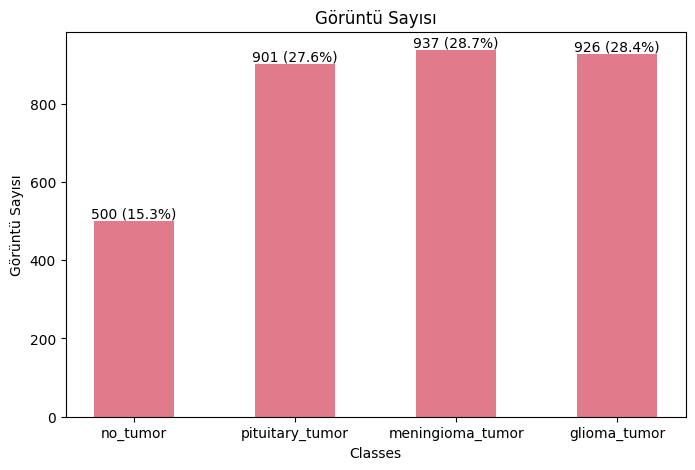

In [ ]:
# Sınıf başına mevcut olan görüntüyü sayma
def count_images_per_class(data, classes):
    count_per_class = {class_name: 0 for class_name in classes}
    for class_idx in data:
        class_name = classes[class_idx]
        count_per_class[class_name] += 1
    return count_per_class

# Sınıf başına görüntü sayısı
train_count_per_class = count_images_per_class(Y_train, classes)

plt.figure(figsize=(8, 5))
#train  data
train_bars = plt.bar(train_count_per_class.keys(), train_count_per_class.values(),
                    color='#E17A8A',
                    width=0.5)  # Sadece sütun genişliğini azalttım
plt.title('Görüntü Sayısı')
plt.xlabel('Classes')
plt.ylabel('Görüntü Sayısı')
# Yüzdelik hesap
for bar in train_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height} ({height / np.sum(list(train_count_per_class.values())) * 100:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()

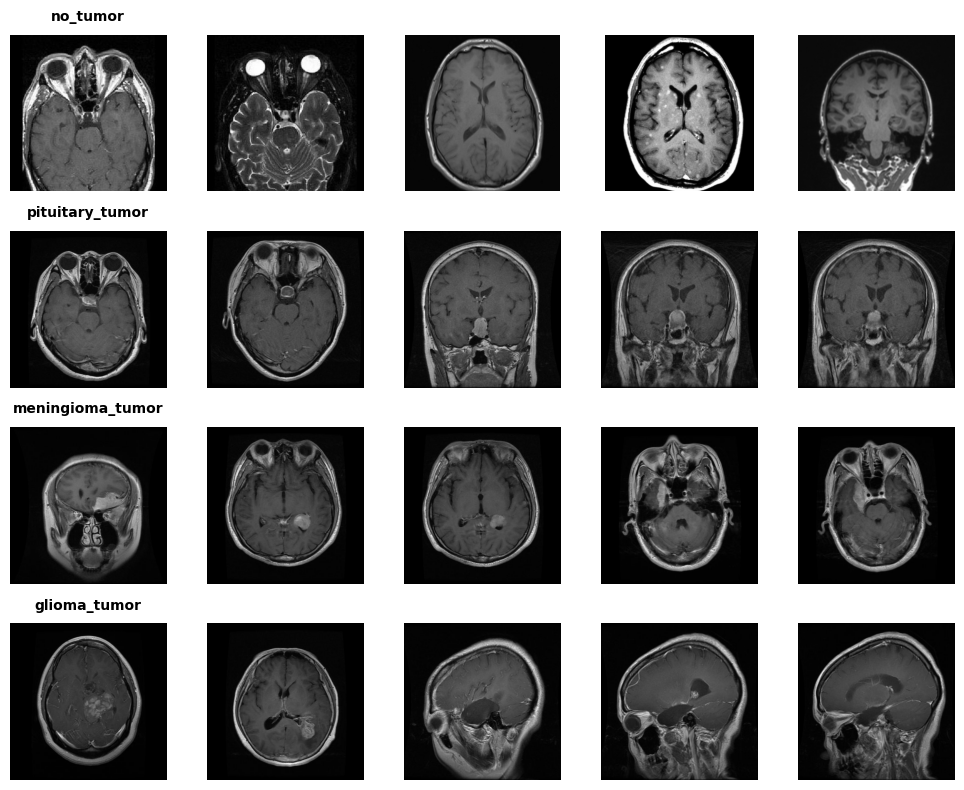

In [ ]:
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Her sınıf için örnek göster
show_examples(X_train, Y_train, classes)

In [ ]:
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)

shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# En Yaygın Boyutun Gösterimi
print("En Sık Görülen Boyut :")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

En Sık Görülen Boyut :
- (512, 512, 3): 2341
- (236, 236, 3): 79
- (225, 225, 3): 43


In [ ]:
shape = (225, 225, 3)

In [ ]:
def crop_image(image):
    # Görüntünün doğru tipte olduğundan emin olun
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Renkli görüntüyü griye dönüştür
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # İkili eşikleme
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Kenarların bulunması
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No contours found in the image. Check the input.")

    # En büyük kenarı bulma
    largest_contour = max(contours, key=cv2.contourArea)

    # Kenara göre kırpma işlemi
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_img = image[y:y+h, x:x+w]

    return cropped_img


In [ ]:
#Tüm Görselleri ön İşlemeden (Kırpılmadan) Geçirilmesi
def preprocess_data(train_data):
  processed_data = []
  for img in tqdm(train_data):

    # Kırpmayı Uygula
    cropped_img = crop_image(img)

    # Önceden belirlediğimiz shape'e göre boyutlandırılması. (222x222x3)
    resized_img = cv2.resize(cropped_img, (shape[1], shape[0]))

    # Görsellerin Normalize Edilmesi
    #normalized_img = resized_img / 255.0
    normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Görüntü ve sınıf adlarının eklenmesi
    processed_data.append(normalized_img)

  return processed_data

# Eğitim ve test verilerinin ön işlenmesi
# Eğitim ve test verilerinin ön işlenmesi
try:
    X_train = preprocess_data(X_train)
    X_train = np.array(X_train)
except Exception as e:
    print(f"An error occurred during preprocessing: {e}")

  0%|          | 0/3264 [00:00<?, ?it/s]

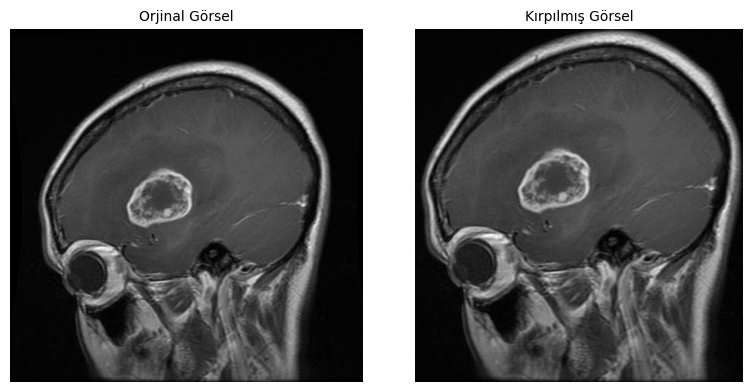

In [ ]:
image_path = "Tumor/Training/glioma_tumor/gg (105).jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


cropped_image = crop_image(img)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Orjinal Görsel", fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_image, cmap='gray')
plt.title("Kırpılmış Görsel", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

# ÖRNEK SINIF GÖRSELLERİ (?)

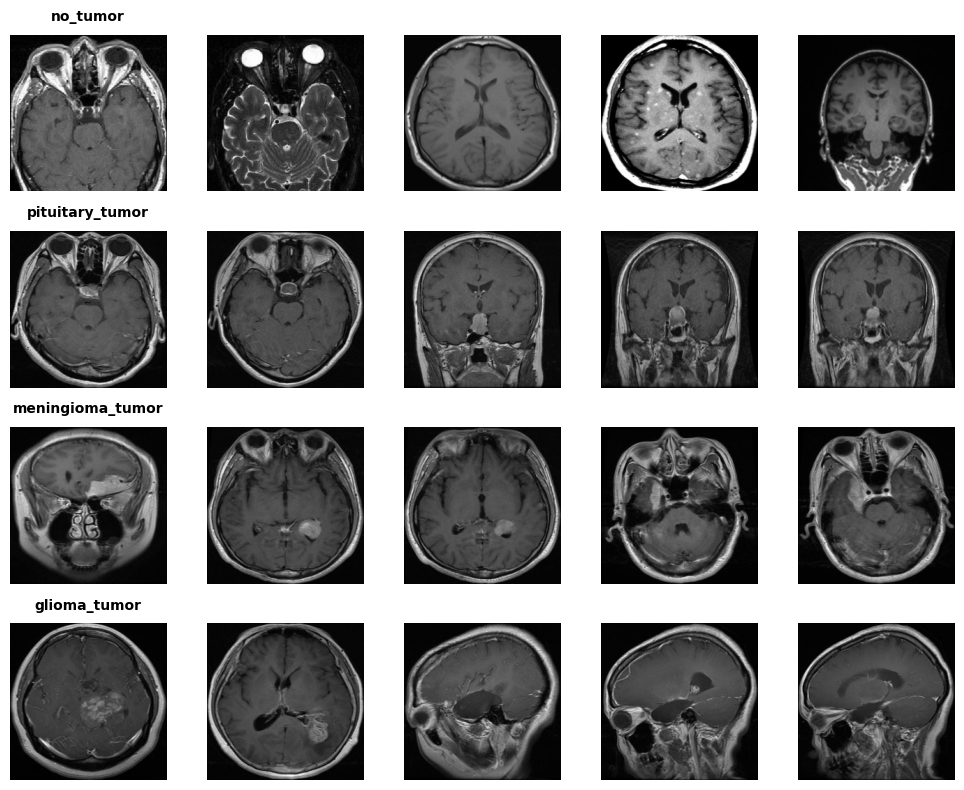

In [ ]:
#  Her sınıf için örnek görseller
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()


show_examples(X_train, Y_train, classes)

In [ ]:
X_train, Y_train = shuffle(X_train,Y_train, random_state=64)

In [ ]:
# Eğitim kümesini test ve train olarak ayrılması
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=64)

In [ ]:
# Test verisinin eğitim ve test olarak ayrılması
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test, test_size=2/3,random_state=64)

# VERİLERİN DAİRESEL GÖSTERİMİ

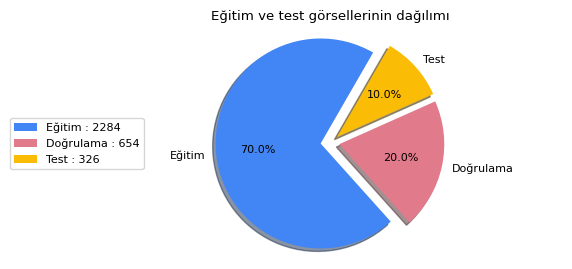

In [ ]:
sizes = [len(Y_train), len(Y_val), len(Y_test)]
labels = ['Eğitim', 'Doğrulama', 'Test']
colors = ['#4285f4', '#E17A8A', '#fbbc05']

plt.figure(figsize=(6, 3))
plt.rcParams.update({'font.size': 8})

# Pasta grafiği
patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%.1f%%',
    explode=(0.1, 0.08, 0.08),
    shadow=True,
    startangle=60
)

# Başlık
plt.title("Eğitim ve test görsellerinin dağılımı")

# Açıklama kutusu sola yerleştirilir
plt.legend(
    patches,
    [f"{label} : {size}" for label, size in zip(labels, sizes)],
    loc="center left",
    bbox_to_anchor=(-0.2, 0.5)  # Sol tarafa taşır
)

plt.axis('equal')  # Dairenin düzgün görünmesi için
plt.show()


In [ ]:
Y_train =  np.array(tensorflow.keras.utils.to_categorical(Y_train))
Y_val =  np.array(tensorflow.keras.utils.to_categorical(Y_val))
Y_test =  np.array(tensorflow.keras.utils.to_categorical(Y_test))

# Veri Arttırma

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow(
    x=np.array(X_train),
    y=np.array(Y_train) # one hot encoding
)

# ARTTIRILMIŞ VERİ ÖRNEKLERİ

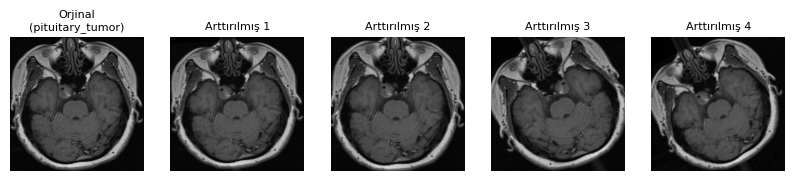

In [ ]:
random_index = np.random.randint(len(X_train))
image = X_train[random_index]
class_label_encoded = Y_train[random_index]
class_label = classes[np.argmax(class_label_encoded)]

# Orjinal Veri gösterimi
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title('Orjinal\n({})'.format(class_label), fontsize=8)
plt.axis('off')

# Arttırılmış veri gösterimi
for i in range(4):
    augmented_image = train_datagen.random_transform(image)
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented_image)
    plt.title('Arttırılmış {}'.format(i + 1), fontsize=8)
    plt.axis('off')

plt.show()

In [ ]:
# Efficentnet Modeli
base_model = EfficientNetB0(include_top=False,
                      input_shape=shape,
                      weights='imagenet')

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

output_tensor = Dense(len(classes), activation='softmax')(x)


EfficientNet_model = Model(inputs=base_model.input, outputs=output_tensor)

# Derleme
EfficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

# Özet
EfficientNet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 225, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 225, 225,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 225, 225,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 227, 227,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 113, 113,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 113, 113,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 113, 113,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 113, 113,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 113, 113,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 113, 113,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 113, 113,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 113, 113,  │        512 │ block1a_se_excit

 Total params: 4,707,495 (17.96 MB)

 Trainable params: 4,665,472 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Batch size belirlenmesi
batch_size = 64
# Boyutların ayarlanması
image_shape = shape
# epoch sayısı
epochs = 1

print(f'Batch size: {batch_size}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')

Batch size: 64
Image shape: (225, 225, 3)
Epochs: 1


In [ ]:
# Eğitim sırasında ReduceLROnPlateau, EarlyStopping ve Checkpoint gibi geri çağırma yöntemlerin eklenmesi.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  #15 epoch  boyunca accurcy artmazs sonlandır
checkpoint = ModelCheckpoint(filepath='Medikal.keras', monitor='val_accuracy', save_best_only=True, verbose=1)  #En iyi ağırlıkların(modelin) kaydedilmesi


In [ ]:
# Model eğitimi
start_time = time.time()
EfficientNet_history = EfficientNet_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr, checkpoint],
    verbose=1
)
end_time = time.time()

c:\Users\Fhyci\OneDrive\Masaüstü\Medikal\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/72 ━━━━━━━━━━━━━━━━━━━━ 5:40 5s/step - accuracy: 0.3642 - loss: 1.2704 - precision: 0.5307 - recall: 0.1413

KeyboardInterrupt: 

In [ ]:
tr_acc = EfficientNet_history.history['accuracy']
tr_loss = EfficientNet_history.history['loss']
tr_per = EfficientNet_history.history['precision']
tr_recall = EfficientNet_history.history['recall']
val_acc = EfficientNet_history.history['val_accuracy']
val_loss = EfficientNet_history.history['val_loss']
val_per = EfficientNet_history.history['val_precision']
val_recall = EfficientNet_history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Eğitim Metrikleri', fontsize=16)
plt.show()


NameError: name 'EfficientNet_history' is not defined

# Model Eğitiminin Değerlendirilmesi (Test Seti)

In [ ]:
# Model Eğitiminin Derğelendirilmesi
train_result = EfficientNet_model.evaluate(X_train,Y_train)

# Test seti performans metrikleri
print("Train Loss: {:.2f}%".format(train_result[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result[1] * 100))
print("Train Precision: {:.2f}%".format(train_result[2] * 100))
print("Train Recall: {:.2f}%".format(train_result[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 790ms/step - accuracy: 0.1639 - loss: 2.9828 - precision: 0.1639 - recall: 0.1639
Train Loss: 304.23%
Train Accuracy: 15.32%
Train Precision: 15.32%
Train Recall: 15.32%


# Model Eğitiminin Değerlendirilmesi (Test Seti)

In [ ]:

train_result = EfficientNet_model.evaluate(X_train,Y_train)

# Metrikler
print("Train Loss: {:.2f}%".format(train_result[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result[1] * 100))
print("Train Precision: {:.2f}%".format(train_result[2] * 100))
print("Train Recall: {:.2f}%".format(train_result[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 739ms/step - accuracy: 0.2726 - loss: 2.7817 - precision_1: 0.2726 - recall_1: 0.2726
Train Loss: 274.15%
Train Accuracy: 27.80%
Train Precision: 27.80%
Train Recall: 27.80%


In [ ]:
predictions = EfficientNet_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1)
y_pred_test = np.argmax(predictions, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 957ms/step


In [ ]:
accuracy = accuracy_score(y_true_test, y_pred_test)
print("Accuracy:{:.2f}%".format(accuracy * 100))

Accuracy:27.91%


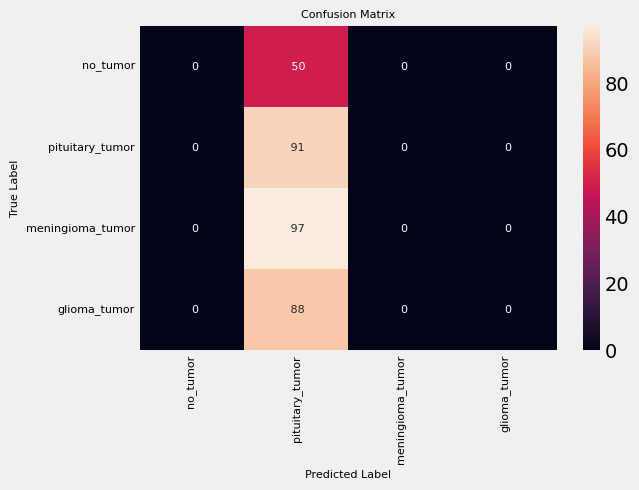

In [ ]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix',fontsize=8)
plt.xlabel('Tahmin Etiketi',fontsize=8)
plt.ylabel('Doğru Etiket',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
class_report = classification_report(y_true_test, y_pred_test, target_names=classes)
print("Classification Report:")
print(class_report)

Classification Report:
                  precision    recall  f1-score   support

        no_tumor       0.00      0.00      0.00        50
 pituitary_tumor       0.28      1.00      0.44        91
meningioma_tumor       0.00      0.00      0.00        97
    glioma_tumor       0.00      0.00      0.00        88

        accuracy                           0.28       326
       macro avg       0.07      0.25      0.11       326
    weighted avg       0.08      0.28      0.12       326



c:\Users\Fhyci\OneDrive\Masaüstü\Medikal\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fhyci\OneDrive\Masaüstü\Medikal\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fhyci\OneDrive\Masaüstü\Medikal\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# ROC EĞRİLERİ

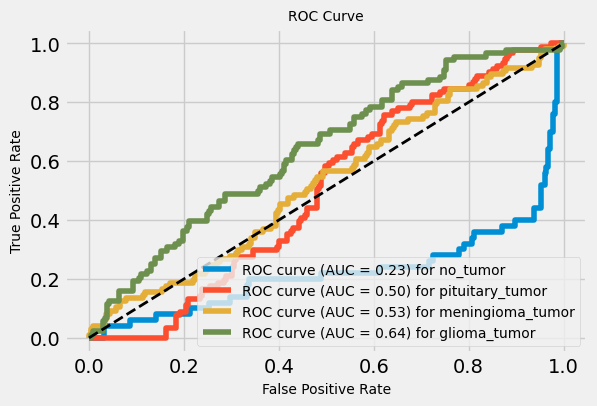

In [ ]:
# Her sınıf için tahmin edilen olasılıklar
y_pred_prob = predictions
y_true_test_OneHot = np.array(tensorflow.keras.utils.to_categorical(y_true_test))
# Her Sınıf için ROC eğlerilerinin hesaplanması
fpr = dict()
tpr = dict()
roc_auc = dict()


plt.figure(figsize=(6,4))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_test_OneHot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}) for {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.show()

In [ ]:
accuracy = accuracy_score(y_true_test, y_pred_test)
print("Accuracy:{:.2f}%".format(accuracy * 100))

Accuracy:27.91%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


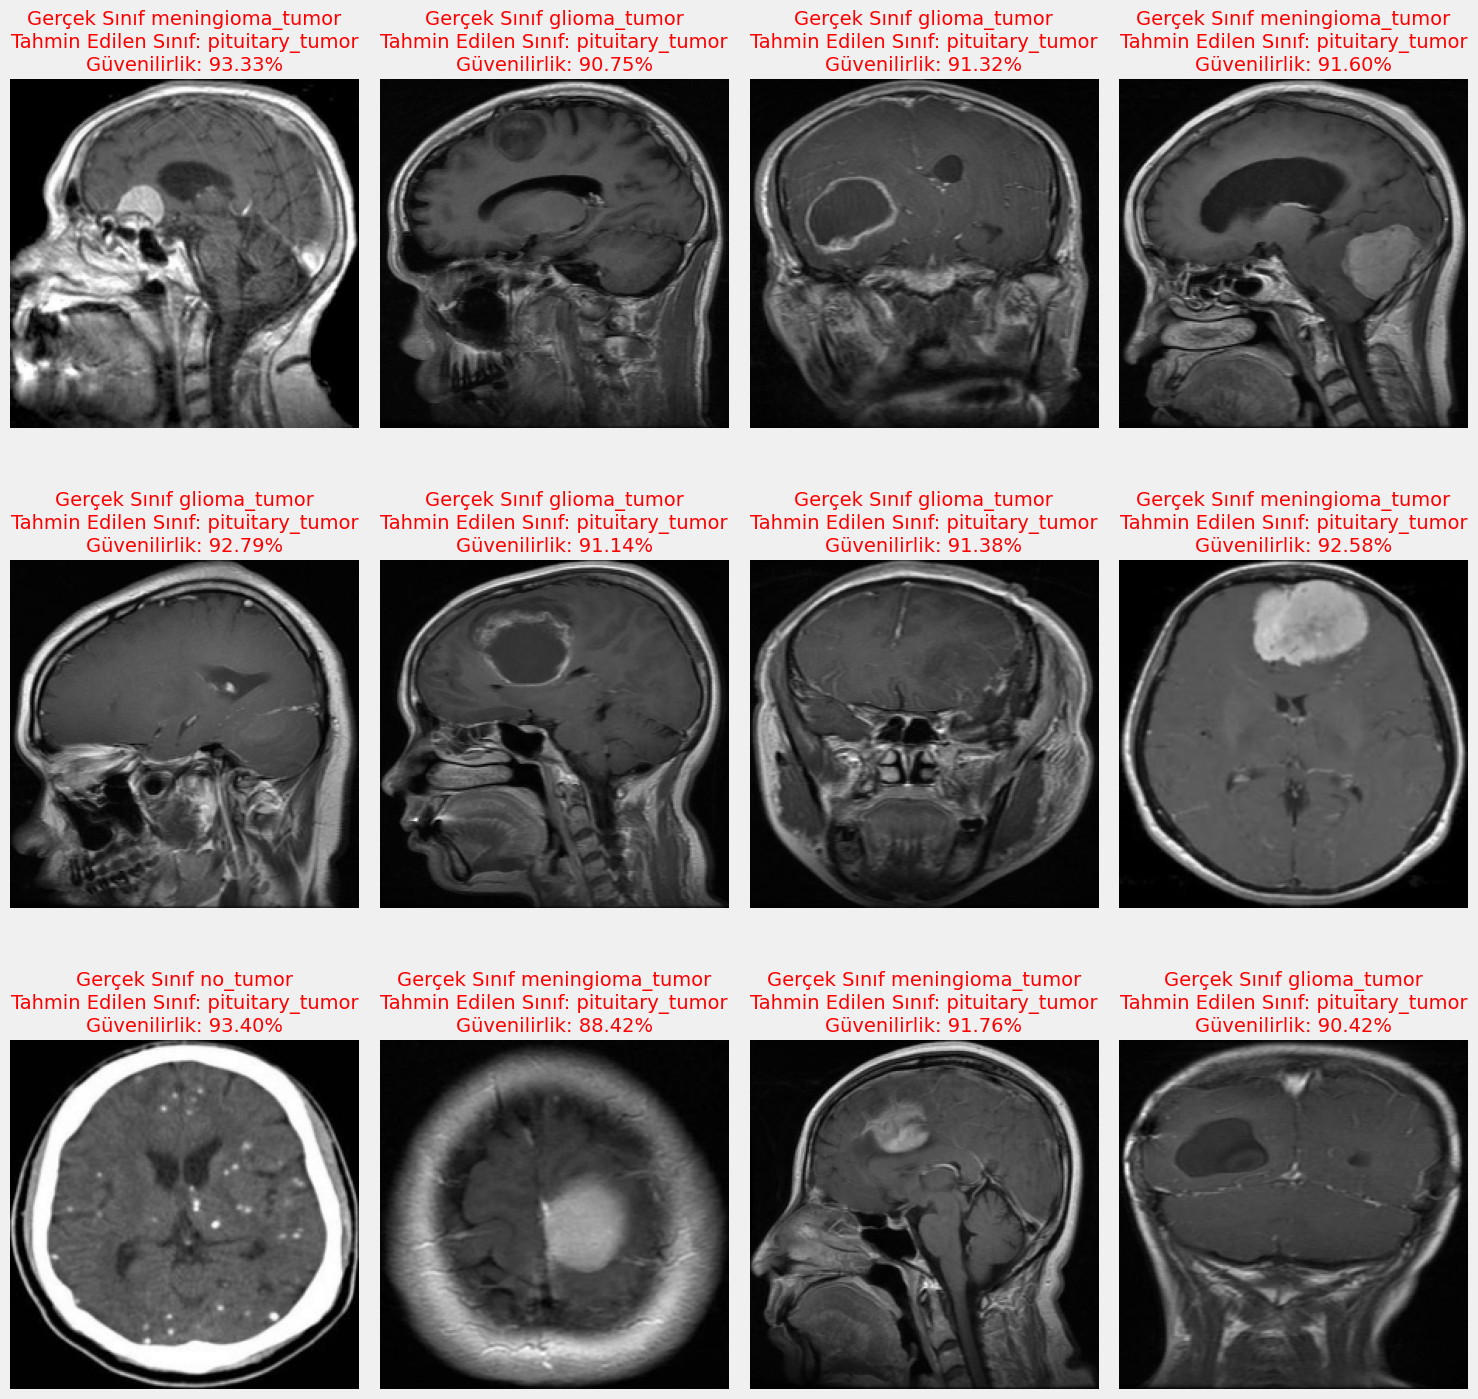

In [ ]:
indices = np.random.choice(len(Y_test), size=12, replace=False)

images = X_test
labels = Y_test

# One-hot encoded formatından gerçek sınıf indekslerine dönüştürme
y_true_test = np.argmax(Y_test, axis=1)  # One-hot encoded'dan indekslere dönüştürme

plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    image = images[idx]
    true_label = classes[y_true_test[idx]]  # Düzeltilmiş satır

    prediction = EfficientNet_model.predict(np.expand_dims(image, axis=0))
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    color = 'green' if true_label == predicted_class else 'red'

    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf {true_label}\nTahmin Edilen Sınıf: {predicted_class}\nGüvenilirlik: {confidence:.2f}%", color=color, fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
y_test :  no_tumor
y_pred :  pituitary_tumor


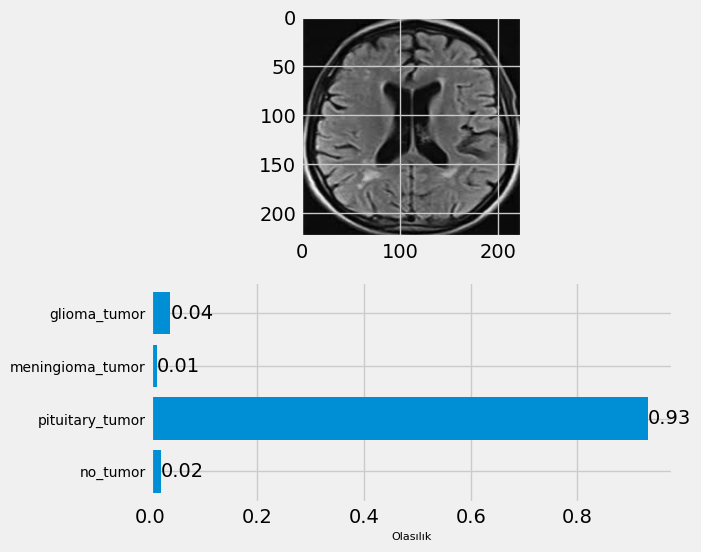

In [ ]:
plt.figure(figsize=(6, 6))
resized_img = cv2.resize(X_test[1], (shape[1], shape[0]))
img = np.asarray(resized_img)
img = np.expand_dims(img, axis=0)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
predictions = EfficientNet_model.predict(img)

# One-hot encoded'dan gerçek sınıf indeksine dönüştürme
true_label_idx = np.argmax(Y_test[1])
print('y_test : ', classes[true_label_idx])

y_pred = np.argmax(predictions, axis=1)
print('y_pred : ', classes[y_pred[0]])

probs = list(predictions[0])
labels = classes

plt.subplot(2, 1, 1)
plt.imshow(resized_img)
plt.subplot(2, 1, 2)
bars = plt.barh(labels, probs)
plt.xlabel('Olasılık', fontsize=8)
ax = plt.gca()
ax.bar_label(bars, fmt='%.2f')
plt.yticks(fontsize=10)
plt.show()